<a href="https://colab.research.google.com/github/Mobad225/Face-Recognition-Eigenfaces-/blob/master/assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downloading Dataset Using Kaggle API

###Open kaggle --> My account --> Create New API Token (Dont rename it) --> Upload it here.

In [0]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mobad225","key":"7f1df67894ef00b7c8c5c20c3f214312"}'}

In [0]:
!pip install -q --upgrade pip
!pip install -q kaggle

     |████████████████████████████████| 1.4MB 2.8MB/s 


In [0]:
!mkdir -p /root/.kaggle
!cp kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [0]:
!kaggle datasets download kasikrit/att-database-of-faces

  0% 0.00/3.61M [00:00<?, ?B/s]
100% 3.61M/3.61M [00:00<00:00, 120MB/s]


In [0]:
!unzip -q att-database-of-faces.zip -d dataset

# Load the dataset into Data matrix 'D' & Label Vector 'y'

In [0]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

path = 'dataset'
files = os.listdir(path)
files.remove('README')
files.sort(key = lambda x : int(x[1:]))
D , y = [], []
ok = 1
for f in files:
  curr_path = path + '/' + f
  images = os.listdir(curr_path)
  #images.sort(key = lambda x : int(x[:-4]))
  for i in images:
    my_path = curr_path + '/' + i
    img = cv2.imread(my_path, cv2.IMREAD_GRAYSCALE).flatten()
    D.append(img)
    y.append(int(f[1:]))

# Split Data to training & test data

In [0]:
X_training_50 = np.array([D[i] for i in range(len(D)) if i&1]).astype(float)
y_training_50 = np.array([y[i] for i in range(len(y)) if i&1]).astype(int)
X_test_50 = np.array([D[i] for i in range(len(D)) if i % 2 == 0]).astype(float)
y_test_50 = np.array([y[i] for i in range(len(y)) if i % 2 == 0]).astype(int)

## Function to return covariance matrix of data after centering it

In [0]:
def get_cov(_M):
  M = np.zeros_like(_M)
  M_mean = _M.mean(0)
  plt.imshow(np.reshape(M_mean, (112, 92)), cmap=plt.get_cmap('gray'))
  plt.title('Average face')
  M = _M - M_mean
  return np.cov(M.T)

### Finding eigenvalues & eigenvectors + sorting them

CPU times: user 8min 5s, sys: 27 s, total: 8min 32s
Wall time: 2min 13s


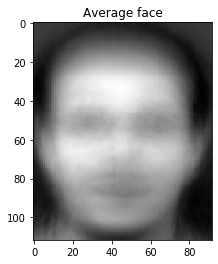

In [0]:
%%time
cov_mat = get_cov(X_training_50)
PCA_eigenvalues_50, PCA_eigenvectors_50 = np.linalg.eigh(cov_mat)
idx = PCA_eigenvalues_50.argsort()[::-1]   
PCA_eigenvalues_50 = PCA_eigenvalues_50[idx]
PCA_eigenvectors_50 = PCA_eigenvectors_50[:,idx]

# For PCA

### Function to return projection matrix based on given epsilon using eigenvalues and eigenvectors

In [0]:
def get_projection(v, w, err):
  tot, taken, it = 0, 0, 0
  for i in range(len(v)):
    tot += v[i]
  proj = []
  while taken/tot < err:
    taken += v[it]
    proj.append(w[:,it])
    it += 1
  return np.array(proj).T

In [0]:
alpha = [0.8, 0.85, 0.9, 0.95]

## Will get projection matrices for each alpha, project the test data, and test samples with the same projection matrices

In [0]:
from sklearn.neighbors import KNeighborsClassifier

For error 0.80, Reduced the 10304 dimensions to 36
For error 0.85, Reduced the 10304 dimensions to 52
For error 0.90, Reduced the 10304 dimensions to 76
For error 0.95, Reduced the 10304 dimensions to 116


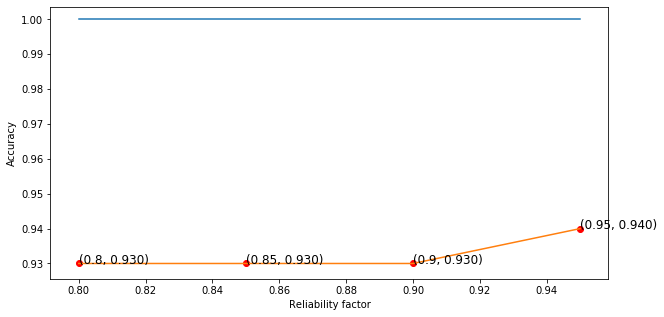

In [0]:
training_scores_50, test_scores_50 = [], []
for error in alpha:
  #Projection matrix
  PCA_P = get_projection(PCA_eigenvalues_50, PCA_eigenvectors_50, error)
  reduced_training_50 = X_training_50.dot(PCA_P)
  reduced_test_50 = X_test_50.dot(PCA_P)
  print('For error %.2f, Reduced the %d dimensions to %d'
        % (error, len(X_training_50[0]), len(PCA_P[0])))
  classifier = KNeighborsClassifier(n_neighbors = 1, weights = 'distance')
  classifier.fit(reduced_training_50, y_training_50)
  training_acc = classifier.score(reduced_training_50, y_training_50)
  test_acc = classifier.score(reduced_test_50, y_test_50)
  training_scores_50.append(training_acc)
  test_scores_50.append(test_acc)
plt.figure(figsize=(10,5))
plt.plot(alpha, training_scores_50, label = 'Training Data')
plt.plot(alpha, test_scores_50, label = 'Test Data')
plt.scatter(alpha, test_scores_50, color = 'r')
for i_x, i_y in zip(alpha, test_scores_50):
    plt.text(i_x, i_y, '({}, {:.3f})'.format(i_x, i_y), fontsize = 12)
plt.xlabel('Reliability factor')
plt.ylabel('Accuracy')
plt.show()
plt.close()

Relation between alpha & accuracy : As alpha increases, Accuracy increases

# For LDA, Calculating mean for each class and calculating the Between-class scatter matrix

### Function to calculate grouped means

In [0]:
def groupedAvg(myArray, N=2):
    result = np.cumsum(myArray, 0)[N-1::N]
    result[1:] = result[1:] - result[:-1]
    return result/float(N)

## Finding $S_{b}$ (between-class scatter matrix)

In [0]:
class_means_50 = np.matrix(groupedAvg(X_training_50, N = 5))
mean_50 = class_means_50.mean(axis = 0)
Sb_50 = np.zeros(shape = (mean_50.shape[1], mean_50.shape[1]))
for i in range(40):
  diff = class_means_50[i] - mean_50
  Sb_50 += 5 * diff.T.dot(diff)

## Finding S (within-class scatter matrix)

### Center the data

In [0]:
X_centered_50 = np.zeros_like(X_training_50)
class_means_50 = np.array(class_means_50)
for i in range(len(X_training_50)):
  X_centered_50[i] = X_training_50[i] - class_means_50[ i//5 ]

### Get S

In [0]:
S_50 = np.zeros_like(Sb_50)
for i in range(40):
  curr = X_centered_50[i * 5 : (i + 1) * 5]
  S_50 += curr.T.dot(curr)

### Find $S^-$$^1$ and find $S^-$$^1$ * $S_{b}$ : 'A'

In [0]:
%%time
S_inv_50 = np.linalg.pinv(S_50, hermitian=True)
A_50 = S_inv_50.dot(Sb_50)

CPU times: user 12min 8s, sys: 23.5 s, total: 12min 32s
Wall time: 3min 12s


In [0]:
print('Matrix inverse is correct : '
      , np.allclose(S_50, np.dot(S_50, np.dot(S_inv_50, S_50))), sep = '')

Matrix inverse is correct : True


### Compute the eigenvalue and eigenvector decomposition + sort

In [0]:
LDA_eigenvalues, LDA_eigenvectors = np.linalg.eig(A_50)
LDA_eigenvalues_abs = np.absolute(LDA_eigenvalues)
idx = LDA_eigenvalues_abs.argsort()[::-1]
LDA_eigenvalues_abs = LDA_eigenvalues_abs[idx]
LDA_eigenvectors = LDA_eigenvectors[:,idx]

## Taking real part of eigenvectors + Finding 'P' Projection matrix

In [0]:
LDA_eigenvectors = np.real(LDA_eigenvectors)
P_LDA_50 = LDA_eigenvectors[:,:39]

## Finding new data

In [0]:
acc_train_50, acc_test_50 = 0, 0
X_lda_train_50 = X_training_50.dot(P_LDA_50)
X_lda_test_50 = X_test_50.dot(P_LDA_50)
#print(X_lda_train.shape, y_training.shape)
LDA_classifier = KNeighborsClassifier(n_neighbors = 1, weights = 'distance')
LDA_classifier.fit(X_lda_train_50, y_training_50)
acc_train = LDA_classifier.score(X_lda_train_50, y_training_50)
acc_test = LDA_classifier.score(X_lda_test_50, y_test_50)

# Plotting LDA Vs PCA Results

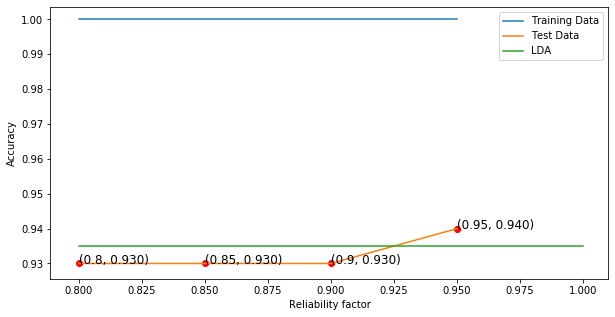

In [0]:
plt.figure(figsize=(10,5))
plt.plot(alpha, training_scores_50, label = 'Training Data')
plt.plot(alpha, test_scores_50, label = 'Test Data')
plt.plot(np.linspace(0.8,1,500), np.repeat(acc_test, 500), label = 'LDA')
plt.scatter(alpha, test_scores_50, color = 'r')
for i_x, i_y in zip(alpha, test_scores_50):
    plt.text(i_x, i_y, '({}, {:.3f})'.format(i_x, i_y), fontsize = 12)
plt.xlabel('Reliability factor')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.close()

# Classifier Tuning

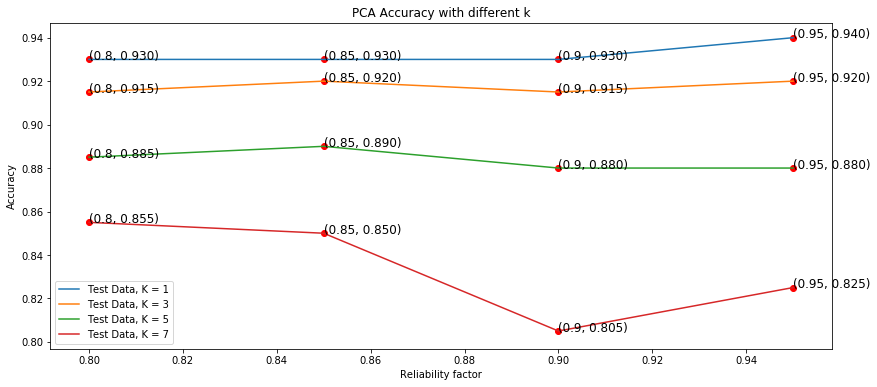

In [0]:
 plt.figure(figsize=(14,6))
 for k in range(1, 8, 2): 
  training_scores_tuning_50, test_scores_tuning_50 = [], []
  for error in alpha:
    #Projection matrix
    P_temp = get_projection(PCA_eigenvalues, PCA_eigenvectors, error)
    reduced_training_50 = X_training_50.dot(P_temp)
    reduced_test_50 = X_test_50.dot(P_temp)
    classifier = KNeighborsClassifier(n_neighbors = k, weights = 'distance')
    classifier.fit(reduced_training_50, y_training_50)
    training_acc = classifier.score(reduced_training_50, y_training_50)
    test_acc = classifier.score(reduced_test_50, y_test_50)
    training_scores_tuning_50.append(training_acc)
    test_scores_tuning_50.append(test_acc)
  plt.plot(alpha, test_scores_tuning_50, label = 'Test Data, K = {}'.format(k))
  #plt.plot(alpha, training_scores, label = 'Training Data, K = {}'.format(k))
  plt.scatter(alpha, test_scores_tuning_50, color = 'r')
  for i_x, i_y in zip(alpha, test_scores_tuning_50):
      plt.text(i_x, i_y, '({}, {:.3f})'.format(i_x, i_y), fontsize = 12)
plt.legend()
plt.xlabel('Reliability factor')
plt.ylabel('Accuracy')
plt.title('PCA Accuracy with different k')
plt.show()
plt.close()


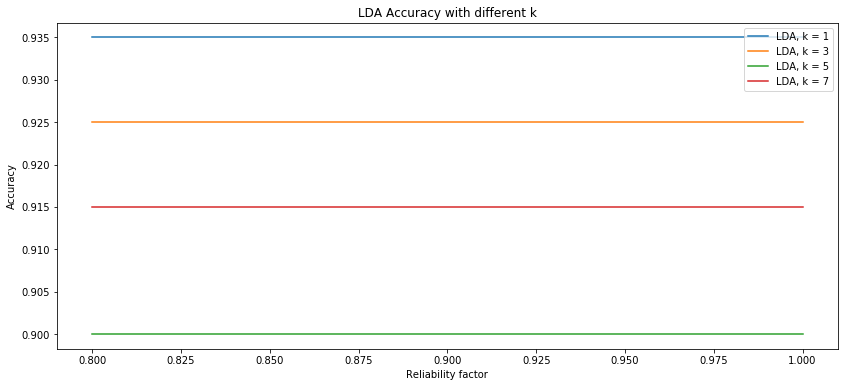

In [0]:
plt.figure(figsize=(14,6))
for k in range(1, 8, 2): 
  acc_train, acc_test = 0, 0
  X_lda_train_50 = X_training_50.dot(P_LDA)
  X_lda_test_50 = X_test_50.dot(P_LDA)
  LDA_classifier = KNeighborsClassifier(n_neighbors = k, weights = 'distance')
  LDA_classifier.fit(X_lda_train_50, y_training_50)
  acc_train = LDA_classifier.score(X_lda_train_50, y_training_50)
  acc_test = LDA_classifier.score(X_lda_test_50, y_test_50)
  #plt.plot(alpha, training_scores, label = 'Training Data')
  plt.plot(np.linspace(0.8,1,500), np.repeat(acc_test, 500),
            label = 'LDA, k = {}'.format(k))
plt.xlabel('Reliability factor')
plt.ylabel('Accuracy')
plt.legend()
plt.title('LDA Accuracy with different k')
plt.show()
plt.close()

## BONUS: Split Training data to 70% and Test data to 30%

In [0]:
X_training_70 = np.array([D[i] for i in range(len(D)) if i % 10 < 7]).astype(float)
y_training_70 = np.array([y[i] for i in range(len(y)) if i % 10 < 7]).astype(int)
X_test_70 = np.array([D[i] for i in range(len(D)) if i % 10 >= 7]).astype(float)
y_test_70 = np.array([y[i] for i in range(len(y)) if i % 10 >= 7]).astype(int)

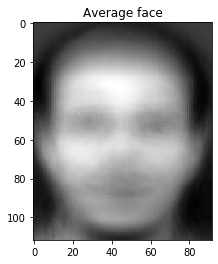

In [0]:
PCA_cov_70 = get_cov(X_training_70)
PCA_eigenvalues_70, PCA_eigenvectors_70 = np.linalg.eigh(PCA_cov_70)
idx = PCA_eigenvalues_70.argsort()[::-1]   
PCA_eigenvalues_70 = PCA_eigenvalues_70[idx]
PCA_eigenvectors_70 = PCA_eigenvectors_70[:,idx]

For error 0.80, Reduced the 10304 dimensions to 40
For error 0.85, Reduced the 10304 dimensions to 60
For error 0.90, Reduced the 10304 dimensions to 92
For error 0.95, Reduced the 10304 dimensions to 148


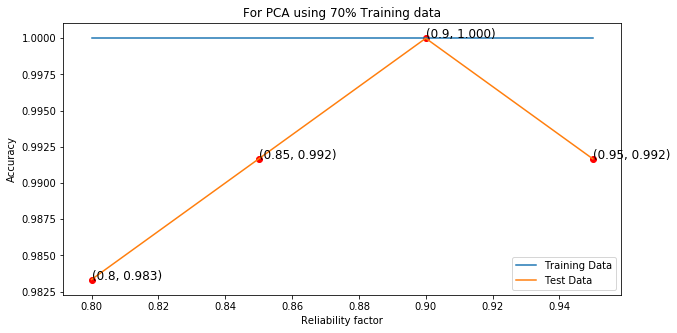

In [0]:
training_scores_70, test_scores_70 = [], []
for error in alpha:
  #Projection matrix
  P_temp = get_projection(PCA_eigenvalues_70, PCA_eigenvectors_70, error)
  reduced_training_70 = X_training_70.dot(P_temp)
  reduced_test_70 = X_test_70.dot(P_temp)
  print('For error %.2f, Reduced the %d dimensions to %d'
        % (error, len(X_training_70[0]), len(P_temp[0])))
  classifier = KNeighborsClassifier(n_neighbors = 1, weights = 'distance')
  classifier.fit(reduced_training_70, y_training_70)
  training_acc = classifier.score(reduced_training_70, y_training_70)
  test_acc = classifier.score(reduced_test_70, y_test_70)
  training_scores_70.append(training_acc)
  test_scores_70.append(test_acc)
plt.figure(figsize=(10,5))
plt.plot(alpha, training_scores_70, label = 'Training Data')
plt.plot(alpha, test_scores_70, label = 'Test Data')
plt.scatter(alpha, test_scores_70, color = 'r')
for i_x, i_y in zip(alpha, test_scores_70):
    plt.text(i_x, i_y, '({}, {:.3f})'.format(i_x, i_y), fontsize = 12)
plt.xlabel('Reliability factor')
plt.ylabel('Accuracy')
plt.title('For PCA using 70% Training data')
plt.legend()
plt.show()
plt.close()

# FOR LDA

In [0]:
class_means_70 = np.matrix(groupedAvg(X_training_70, N = 7))
mean_70 = class_means_70.mean(axis = 0)
Sb_70 = np.zeros(shape = (mean_70.shape[1], mean_70.shape[1]))
for i in range(40):
  diff = class_means_70[i] - mean_70
  Sb_70 += 7 * diff.T.dot(diff)

# Center the Data

In [0]:
X_centered_70 = np.zeros_like(X_training_70)
class_means_70 = np.array(class_means_70)
for i in range(len(X_training_70)):
  X_centered_70[i] = X_training_70[i] - class_means_70[ i//7 ]

In [0]:
S_70 = np.zeros_like(Sb_70)
for i in range(40):
  curr = X_centered_70[i * 7 : (i + 1) * 7]
  S_70 += curr.T.dot(curr)

In [0]:
%%time
S_inv_70 = np.linalg.pinv(S_70, hermitian=True)
A_70 = S_inv_70.dot(Sb_70)

CPU times: user 12min 20s, sys: 32.6 s, total: 12min 52s
Wall time: 3min 20s


In [0]:
print('Matrix inverse is correct : '
      , np.allclose(S_70, np.dot(S_70, np.dot(S_inv_70, S_70))), sep = '')

Matrix inverse is correct : True


In [0]:
LDA_eigenvalues_70, LDA_eigenvectors_70 = np.linalg.eig(A_70)
idx = LDA_eigenvalues_70.argsort()[::-1]
LDA_eigenvalues_70 = LDA_eigenvalues_70[idx]
LDA_eigenvectors_70 = LDA_eigenvectors_70[:,idx]

In [0]:
LDA_eigenvectors_70 = np.real(LDA_eigenvectors_70)
P_LDA_70 = LDA_eigenvectors_70[:,:39]

In [0]:
acc_train, acc_test = 0, 0
X_lda_train_70 = X_training_70.dot(P_LDA_70)
X_lda_test_70 = X_test_70.dot(P_LDA_70)
#print(X_lda_train.shape, y_training.shape)
LDA_classifier = KNeighborsClassifier(n_neighbors = 1, weights = 'distance')
LDA_classifier.fit(X_lda_train_70, y_training_70)
acc_train = LDA_classifier.score(X_lda_train_70, y_training_70)
acc_test = LDA_classifier.score(X_lda_test_70, y_test_70)

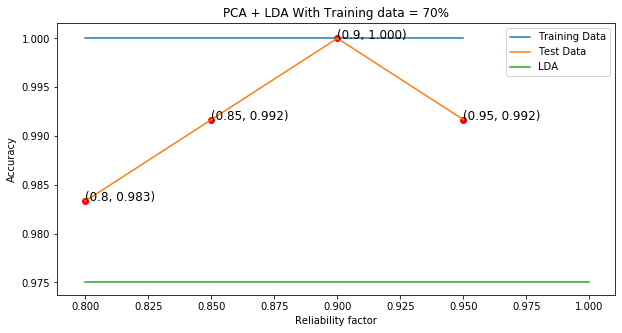

In [0]:
plt.figure(figsize=(10,5))
plt.plot(alpha, training_scores_70, label = 'Training Data')
plt.plot(alpha, test_scores_70, label = 'Test Data')
plt.plot(np.linspace(0.8,1,500), np.repeat(acc_test, 500), label = 'LDA')
plt.scatter(alpha, test_scores_70, color = 'r')
for i_x, i_y in zip(alpha, test_scores_70):
    plt.text(i_x, i_y, '({}, {:.3f})'.format(i_x, i_y), fontsize = 12)
plt.xlabel('Reliability factor')
plt.ylabel('Accuracy')
plt.legend()
plt.title('PCA + LDA With Training data = 70%')
plt.show()
plt.close()

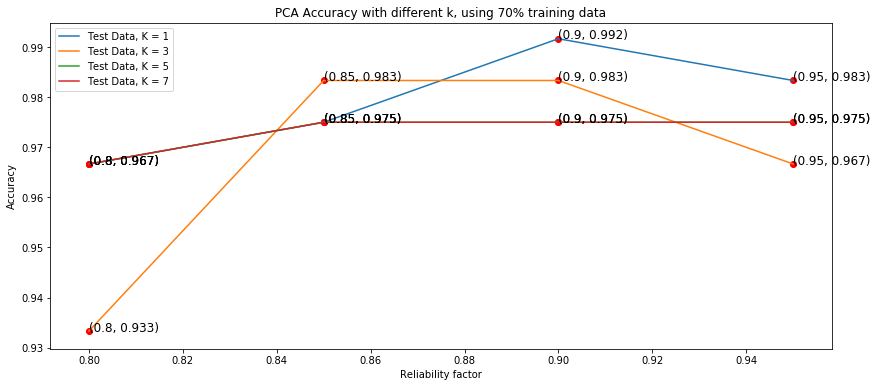

In [0]:
 plt.figure(figsize=(14,6))
 for k in range(1, 8, 2): 
  training_scores_tuning_70, test_scores_tuning_70 = [], []
  for error in alpha:
    #Projection matrix
    P_temp = get_projection(LDA_eigenvalues_70, LDA_eigenvectors_70, error)
    reduced_training_70 = X_training_70.dot(P_temp)
    reduced_test_70 = X_test_70.dot(P_temp)
    classifier = KNeighborsClassifier(n_neighbors = k, weights = 'distance')
    classifier.fit(reduced_training_70, y_training_70)
    training_acc = classifier.score(reduced_training_70, y_training_70)
    test_acc = classifier.score(reduced_test_70, y_test_70)
    training_scores_tuning_70.append(training_acc)
    test_scores_tuning_70.append(test_acc)
  plt.plot(alpha, test_scores_tuning_70, label = 'Test Data, K = {}'.format(k))
  #plt.plot(alpha, training_scores, label = 'Training Data, K = {}'.format(k))
  plt.scatter(alpha, test_scores_tuning_70, color = 'r')
  for i_x, i_y in zip(alpha, test_scores_tuning_70):
      plt.text(i_x, i_y, '({}, {:.3f})'.format(i_x, i_y), fontsize = 12)
plt.legend()
plt.xlabel('Reliability factor')
plt.ylabel('Accuracy')
plt.title('PCA Accuracy with different k, using 70% training data')
plt.show()
plt.close()


In [0]:
!pip install -q tensorflow

In [0]:
ims = os.listdir()
print(ims)
ims.remove('.ipynb_checkpoints')
for xx in ims:
  os.remove(xx)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



[]
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-132-93c2905deb07>", line 3, in <module>
    ims.remove('.ipynb_checkpoints')
ValueError: list.remove(x): x not in list

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 1823, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'ValueError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/local/lib/python3.6/dist-packages/IPython

ValueError: ignored

In [0]:
os.chdir('/content')

In [0]:
try:
    os.mkdir(os.getcwd() + '/PCA_Eigenfaces')
except OSError:
    print ("Creation of the directory failed")
else:
    print ("Successfully created the directory")

Successfully created the directory


In [0]:
import tensorflow as tf
from keras.preprocessing.image import save_img

path = os.getcwd() + '/PCA_Eigenfaces' + '/eigenface'
for num in range(30):
  eigenface = np.reshape(P[:,num], (112, 92))
  #plt.imshow(np.reshape(eigenface, (112, 92)), cmap=plt.get_cmap('gray'))
  #plt.show()
  #plt.close()
  #plt.imsave(path + str(num) + '.png', eigenface, format='png', cmap='gray')

In [0]:
try:
    os.mkdir(os.getcwd() + '/LDA_Eigenfaces')
except OSError:
    print ("Creation of the directory failed")
else:
    print ("Successfully created the directory")

Successfully created the directory


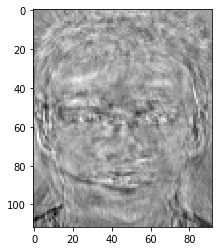

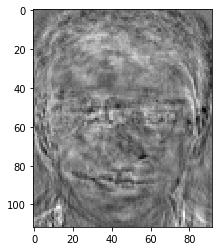

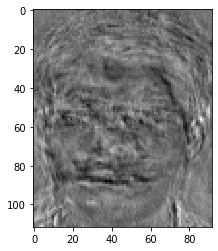

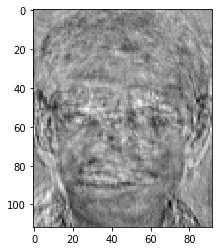

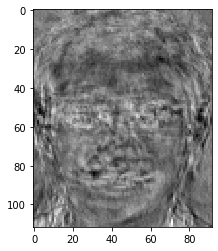

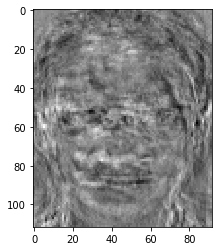

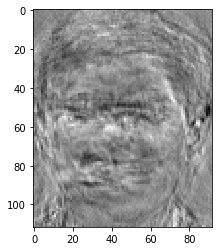

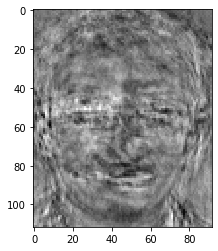

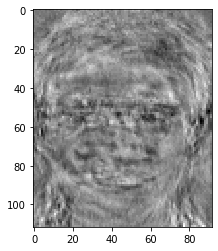

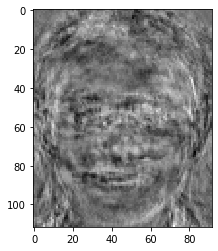

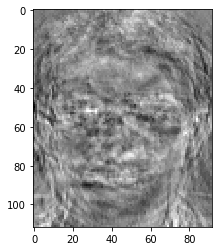

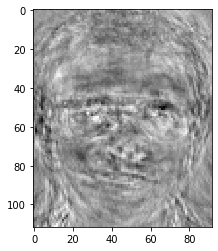

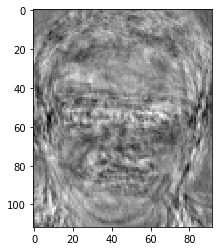

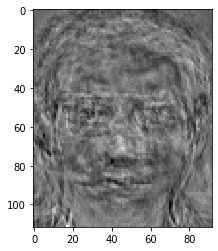

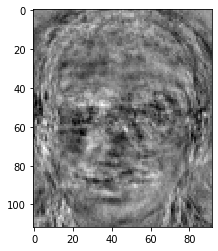

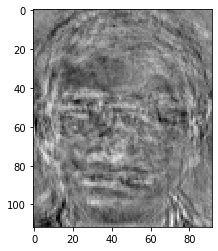

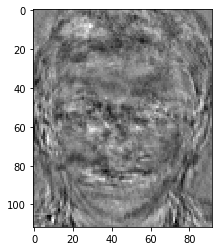

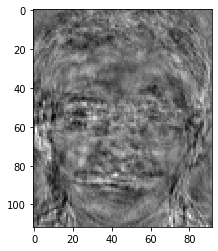

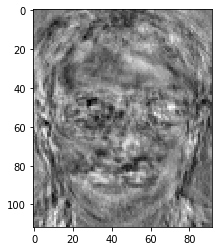

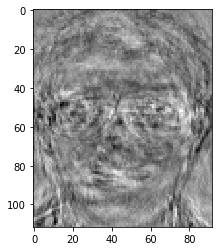

In [0]:
path = os.getcwd() + '/LDA_Eigenfaces' + '/eigenface'
for num in range(20):
  eigenface = np.reshape(P_LDA_50[:,num], (112, 92))
  plt.imshow(np.reshape(eigenface, (112, 92)), cmap=plt.get_cmap('gray'))
  plt.show()
  plt.close()
  #plt.imsave(path + str(num) + '.png', eigenface, format='png', cmap='gray')

In [0]:
!zip -r -q /content/LDA_Eigenfaces.zip /content/LDA_Eigenfaces
!zip -r -q /content/PCA_Eigenfaces.zip /content/PCA_Eigenfaces

In [0]:
files.download("/content/LDA_Eigenfaces.zip")
files.download("/content/PCA_Eigenfaces.zip")